### Import libraries

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import my_dlc_utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Set directory and read files

In [51]:
data_dir = "/Users/anacarolinabotturabarros/PycharmProjects/OPL/pose_files/"
mouse_ids = [f for f in os.listdir(data_dir) if (os.path.isdir(os.path.join(data_dir, f)))]
# files_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if
#               (f.endswith(".csv"))]

# print(files_list)
# print(mouse_ids)

In [52]:
# code to go through all mice and all sessions

for m_n, mouse in enumerate(mouse_ids):
    mouse_folder = os.path.join(data_dir, mouse)
    dates = [f for f in os.listdir(mouse_folder) if (os.path.isdir(os.path.join(mouse_folder, f)))]
    for s, session in enumerate(dates):
        session_file = [f for f in os.listdir(os.path.join(mouse_folder, session)) if (f.endswith(".csv"))]
        session_file = os.path.join(mouse_folder, session, session_file[0])
        file = pd.read_csv(session_file, header=[1,2], index_col=0)
    # subjects[mouse_order[m_n]].name = mouse_order[m_n]
# examples on how to use the subjects dictionary (maybe want to change to a simple list - but it will depend on analysis)

# subjects['mA0'].head() # prints top part of the dataframe
# subjects['mA0']['nose','x'] # call for a specific column
# subjects['mA0'].columns.get_level_values(0).drop_duplicates() # get column names for the different indices

In [53]:
def read_session_csv(data_dir, mouse_id, session_date):
    session_path = os.path.join(data_dir, mouse_id, session_date)
    session_files = [f for f in os.listdir(session_path) if (f.endswith(".csv"))]
    session_csv = os.path.join(session_path, session_files[0])
    df = pd.read_csv(session_csv, header=[1,2], index_col=0)
    df.name = mouse_id+"_"+session_date
    return df

In [222]:
mouse = 'mA0'
session = '20210311'

sess_df = read_session_csv(data_dir, mouse, session)

# sess_df.head() # prints top part of the dataframe
# sess_df['nose','x'] # call for a specific column
# sess_df.columns.get_level_values(0).drop_duplicates() # get column names for the different indices

## Analysis

if it is a *no objects* session:

data to extract:
- trajectory (trace and heatmap)
- time in each half

if it has objects:
- trajectory (trace and heatmap)
- time in each half
- distance to objects / time within a certain distance


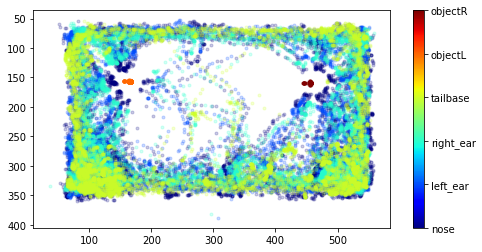

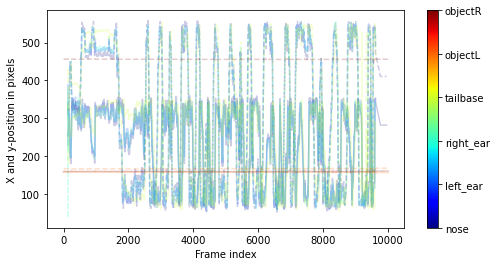

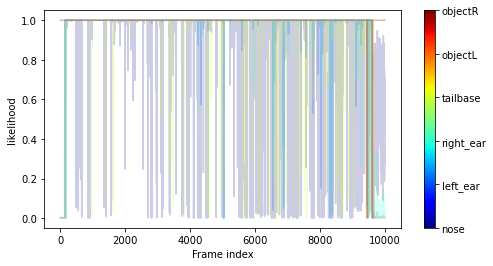

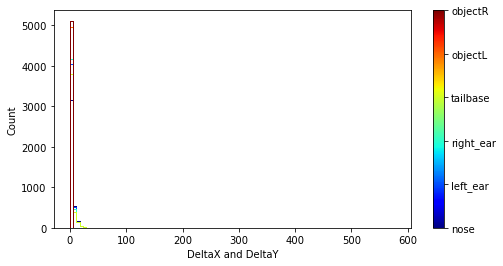

In [223]:
# for all files
# data to extract:
# - trajectory (trace and heatmap)
# - time in each half

Dataframe = sess_df
bps_to_plot=Dataframe.columns.get_level_values(0).drop_duplicates() #you can read out the header to get body part names!
#you could also take a subset, i.e. =['snout']

my_dlc_utils.PlottingResults(Dataframe,bps_to_plot,alphavalue=.2,pcutoff=.9,fs=(8,4))

In [224]:
# find objects position
objR = Dataframe['objectR'][Dataframe['objectR','likelihood'] > 0.9].mean()
objL = Dataframe['objectL'][Dataframe['objectL','likelihood'] > 0.9].mean()
objR.name = 'Right'
objL.name = 'Left'
objs = [objL, objR]
obj_radius = 19.0 # in pixels measured based on one video (see notes about Box)
analysis_radius_cm = 2
analysis_radius_px = 9.8*analysis_radius_cm # 9.8 pixels/cm based on measurement in one video
total_radius = obj_radius + analysis_radius_px

In [225]:
def check_bp_in_circle(radius,center,bp_point):
    if ((bp_point[0] - center[0])**2+(bp_point[1] - center[1])**2) <= (radius**2):
        return True
    else:
        return False

def frames_in_area(bp_df,area_settings):
    if area_settings['type'] == 'circle':
        in_area = []
        for frame in bp_df.index:
            in_area.append(check_bp_in_circle(area_settings['radius'],area_settings['center'], bp_df.loc[frame]))
        bp_df['in'+area_settings['center'].name] = in_area
        return bp_df

In [226]:
chosen_bp = 'nose'
bp_df = Dataframe[chosen_bp][Dataframe['nose','likelihood'] > 0.6][['x','y']]

# this is to check how many "missing" frames we get....
# most are 1 frame skip so maybe could extrapolate, but need to check further.
print(np.diff(bp_df.index).max())
# plt.xlim(0,20)
# plt.hist(np.diff(bp_df.index),100)
# print(max(bp_df.index.diff()))

60


In [227]:
frames_in_area(bp_df, {'type':'circle', 'radius': total_radius, 'center':objs[0]})
frames_in_area(bp_df, {'type':'circle', 'radius': total_radius, 'center':objs[1]})

coords,x,y,inLeft,inRight
132,NaN,357.114502,False,False
134,NaN,326.126740,False,False
135,326.875183,258.110840,False,False
136,322.867340,252.137238,False,False
137,319.415924,255.382660,False,False
...,...,...,...,...
9983,NaN,281.620911,False,False
9996,NaN,281.682007,False,False
9997,NaN,280.564178,False,False
9998,NaN,280.519958,False,False


In [228]:
print('Results for Object {}'.format(objs[0].name))
print('Number of frames where the {} was inside the perimeter: {}'.format(chosen_bp, bp_df['in'+objs[0].name].sum()))
print('Proportion of time inside the perimeter: {}'.format((bp_df['in'+objs[0].name].sum())/len(bp_df['in'+objs[0].name])))

print('Results for Object {}'.format(objs[1].name))
print('Number of frames where the {} was inside the perimeter: {}'.format(chosen_bp, bp_df['in'+objs[1].name].sum()))
print('Proportion of time inside the perimeter: {}'.format((bp_df['in'+objs[1].name].sum())/len(bp_df['in'+objs[0].name])))

Results for Object Left
Number of frames where the nose was inside the perimeter: 284
Proportion of time inside the perimeter: 0.03384982121573302
Results for Object Right
Number of frames where the nose was inside the perimeter: 175
Proportion of time inside the perimeter: 0.020858164481525627


In [229]:
# loop through session values for nose and check if they are inside the circle
# save this as an array of True and False which can be used as an index
# to know how many interactions --> how to save this
# to know how many frames had the nose close you can sum up the amount of frames
# write a function that counts interactions of a certain minimum time

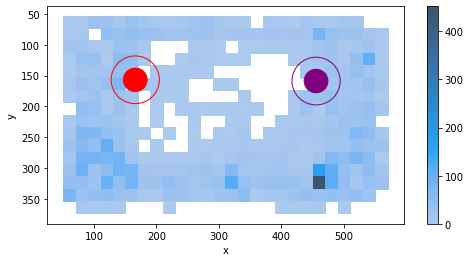

In [230]:
# plotting a heatmap
bp = 'nose'
ind = Dataframe[bp, 'likelihood'] > 0.9
f = plt.figure(figsize=(8,4))
ax = f.subplots()
sns.histplot(Dataframe[bp][ind],x='x', y='y', cbar=True, ax=ax, binwidth=(20, 20))
circle1 = plt.Circle((objs[0]['x'],objs[0]['y']) , total_radius, facecolor='none', edgecolor='r')
circle2 = plt.Circle((objs[1]['x'],objs[1]['y']) , total_radius, edgecolor='purple', facecolor='none')
circle11 = plt.Circle((objs[0]['x'],objs[0]['y']) , obj_radius, color='r')
circle22 = plt.Circle((objs[1]['x'],objs[1]['y']) , obj_radius, color='purple')
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle11)
ax.add_patch(circle22)
ax.invert_yaxis()